In [43]:
CUDA_LAUNCH_BLOCKING = "1"
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed

# Show Infrared Image

In [12]:
# PREFIX = '/kaggle/input/vesuvius-challenge/train/1/'
PREFIX = '../data/train/1/'
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 8   # Number of slices in the z direction
TRAINING_STEPS = 30000
LEARNING_RATE = 0.03
BATCH_SIZE = 24
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cmap values are  'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

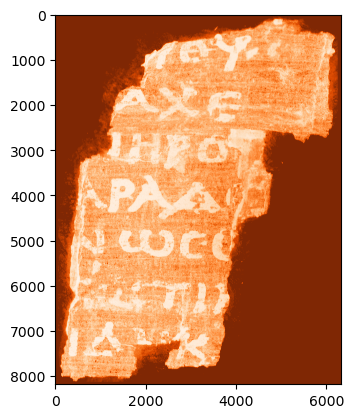

In [12]:
plt.imshow(Image.open(PREFIX+"ir.png"), cmap="Oranges")

Let's load these binary images:

    mask.png: a mask of which pixels contain data, and which pixels we should ignore.
    inklabels.png: our label data: whether a pixel contains ink or no ink (which has been hand-labeled based on the infrared photo).

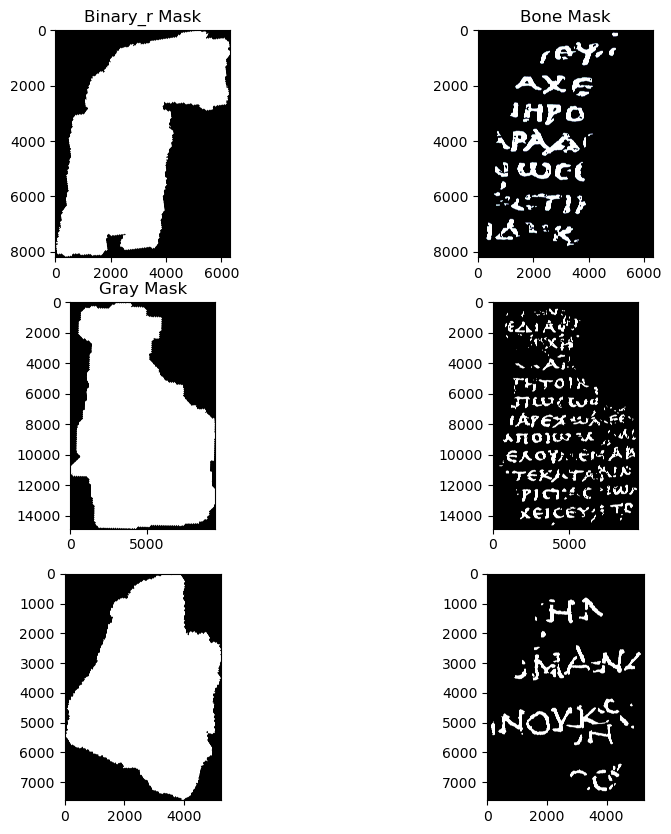

In [25]:
mask1 = np.array(Image.open("../data/train/1/mask.png").convert('1'))
label1 = torch.from_numpy(np.array(Image.open("../data/train/1/inklabels.png"))).gt(0).float().to(DEVICE)
mask2 = np.array(Image.open("../data/train/2/mask.png").convert('1'))
label2 = torch.from_numpy(np.array(Image.open("../data/train/2/inklabels.png"))).gt(0).float().to(DEVICE)
mask3 = np.array(Image.open("../data/train/3/mask.png").convert('1'))
label3 = torch.from_numpy(np.array(Image.open("../data/train/3/inklabels.png"))).gt(0).float().to(DEVICE)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
# axs = axs.flatten()

# pic = plt.imread(file)
axs[0, 0].set(title="Binary_r Mask")
axs[0, 0].imshow(mask1, cmap='binary_r')
axs[0, 1].set(title="Bone Mask")
axs[0, 1].imshow(label1.cpu(), cmap='bone')
axs[1, 0].set(title="Gray Mask")
axs[1, 0].imshow(mask2, cmap='gray')
axs[1, 1].imshow(label2.cpu(), cmap='gray')
axs[2, 0].imshow(mask3, cmap='binary_r')
axs[2, 1].imshow(label3.cpu(), cmap='binary_r')

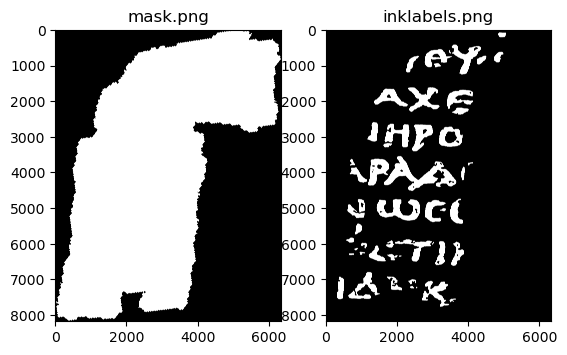

In [16]:
mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='binary_r')
ax2.set_title("inklabels.png")
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

Next, we'll load the 3d x-ray of the fragment. This is represented as a .tif image stack.
The image stack is an array of 16-bit grayscale images.
Each image represents a "slice" in the z-direction, going from below the papyrus, to above the papyrus.

We'll convert it to a 4D tensor of 32-bit floats. We'll also convert the pixel values to the range [0, 1].

To save memory, we'll only load the innermost slices (Z_DIM of them). Let's look at them when we're done

In [5]:
im = Image.open("../data/train/2/surface_volume/33.tif")
# np.array(Image.open(filename), dtype=np.float32)

C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [13]:
im.size  # (9506, 14830) (width, height)

9506

In [16]:
npim = np.array(im, dtype=np.float16)
print(type(im))  # PIL.TiffImagePlugin.TiffImageFile
print(type(npim))  # numpy.ndarray

<class 'PIL.TiffImagePlugin.TiffImageFile'>
<class 'numpy.ndarray'>


In [23]:
npim.size  # 140_973_980 or 9506 * 14830
# so 65 layers would be 9_163_308_700 pixels

(14830, 9506)

In [30]:
npim[102][1110]

0.0

In [31]:
normalim = np.array(Image.open("../data/train/2/surface_volume/33.tif"), dtype=np.float32)/65535.0
normalim.shape

C:\Users\gamer\.conda\envs\vesuvius\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(14830, 9506)

In [22]:
normalim.size

140973980

In [34]:
del normalim
del im
del npim
gc.collect()

NameError: name 'normalim' is not defined

In [3]:
torch.cuda.empty_cache()

In [36]:
# Load the 3d x-ray scan, one slice at a time
images = [np.array(Image.open(filename), dtype=np.float16)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]

100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


In [37]:
# torch.stack concatenates a seq of tensors along a new dimension
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

ValueError: 'grey' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

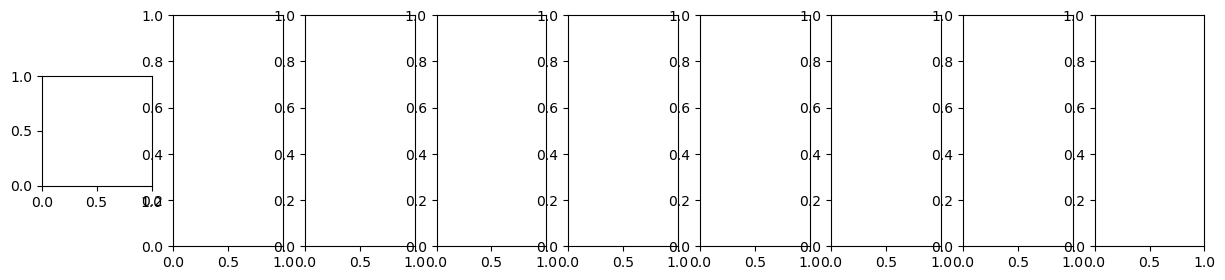

In [62]:
fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
    ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='grey')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

Can you see the ink in these slices of the 3d x-ray scan..? Neither can we.

Now we'll create a dataset of subvolumes. We use a small rectangle around the letter "P" for our evaluation, and we'll exclude those pixels from the training set. (It's actually a Greek letter "rho", which looks similar to our "P".)

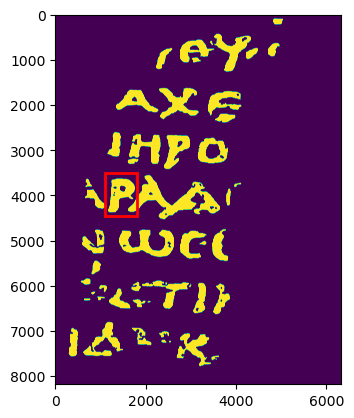

In [17]:
rect = (1100, 3500, 700, 950)
fig, ax = plt.subplots()
ax.imshow(label.cpu())
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

Now we'll define a PyTorch dataset and (super simple) model.

# Begin Dataload

In [19]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel

model = nn.Sequential(
    nn.Conv3d(1, 16, 3, 1, 1), nn.Dropout3d(0.2), nn.MaxPool3d(2, 2),
    nn.Conv3d(16, 32, 3, 1, 1), nn.Dropout3d(0.2), nn.MaxPool3d(2, 2),
    nn.Conv3d(32, 64, 3, 1, 1), nn.Dropout3d(0.2), nn.MaxPool3d(2, 2),
    nn.Flatten(start_dim=1),
    nn.LazyLinear(128), nn.ReLU(),
    nn.Dropout(0.2),
    nn.LazyLinear(1), nn.Sigmoid()
).to(DEVICE)

In [26]:
mask.shape[1]

6330

In [28]:
print("Generating pixel lists...")
# Split our dataset into train and val. The pixels inside the rect are the
# val set, and the pixels outside the rect are the train set.
pixels_inside_rect = []
pixels_outside_rect = []
for pixel in zip(*np.where(mask == 1)):  # Pixel should be a tuple? coordinates
    if pixel[1] < BUFFER or pixel[1] >= mask.shape[1]-BUFFER or pixel[0] < BUFFER or pixel[0] >= mask.shape[0]-BUFFER:
        continue # Too close to the edge

# if pixel[1] >= rect[0] and pixel[1] <= rect[0]+rect[2] and pixel[0] >= rect[1] and pixel[0] <= rect[1]+rect[3]:
    if rect[0] <= pixel[1] <= rect[0]+rect[2] and rect[1] <= pixel[0] <= rect[1] + rect[3]:
        pixels_inside_rect.append(pixel)
    else:
        pixels_outside_rect.append(pixel)

Generating pixel lists...


In [34]:
label.shape

torch.Size([8181, 6330])

In [44]:
print("Training...")
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# criterion = nn.BCELoss()
criterion=nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
print("Model.train")
model.train()

# running_loss = 0.0
print("do the for loop")
for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS):
    if i >= TRAINING_STEPS:
        break
    optimizer.zero_grad()
    outputs = model(subvolumes.to(DEVICE))
    print('Before the loss function')
    loss = criterion(outputs, inklabels.to(DEVICE))
    loss.backward()
    optimizer.step()
    scheduler.step()
    # running_loss += loss.item()
    # if i % 3000 == 3000-1:
    #     print("Loss:", running_loss / 3000)
    #     running_loss = 0.0

  0%|          | 0/30000 [00:00<?, ?it/s]

Training...
Model.train
do the for loop


  0%|          | 0/30000 [00:01<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
eval_dataset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
output = torch.zeros_like(label).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        for j, value in enumerate(model(subvolumes.to(DEVICE))):
            output[pixels_inside_rect[i*BATCH_SIZE+j]] = value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

In [ ]:
THRESHOLD = 0.4
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.gt(THRESHOLD).cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

# Submission

In [ ]:
def rle(output):
    flat_img = np.where(output.flatten().cpu() > THRESHOLD, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))
rle_output = rle(output)
# This doesn't make too much sense, but let's just output in the required format
# so notebook works as a submission. :-)
print("Id,Predicted\na," + rle_output + "\nb," + rle_output, file=open('submission.csv', 'w'))